# Kaggle Challenge: West Nile Virus Prediction
https://www.kaggle.com/c/predict-west-nile-virus/overview

In [167]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, time, timedelta
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Clean and Format Data

In [2]:
# Define directory information
projdir = '/Users/klarnemann/Documents/DataChallenges/predict-west-nile-virus'
datadir = '%s/data' % (projdir)

In [3]:
# Load data
spray_df = pd.read_csv('%s/spray.csv' % (datadir))
test_df = pd.read_csv('%s/test.csv' % (datadir))
train_df = pd.read_csv('%s/train.csv' % (datadir))
weather_df = pd.read_csv('%s/weather.csv' % (datadir))

In [4]:
def fill_missing_data(df, drop_cols, missing_vals=['M','-'], fill_val=np.nan):
    '''Remove missing values from DataFrame.
    
    Parameters
    ----------
    df : pandas.DataFrame
    drop_cols : list (list of columns in df)
    missing_vals : list (list of entries indicating missing data)
    fill_val : float, int, str, etc (value to set missing data)
    '''
    df = df.copy()
    for col in df.columns:
        for val in missing_vals:
            mask = df[col] == val
            df.loc[mask, col] = fill_val
    df.drop(drop_cols, axis=1, inplace=True)
    return df

def fill_trace_data(df, trace_cols=['SnowFall', 'PrecipTotal'], fill_vals=[0.001, 0.0001]):
    '''Set trace (i.e. 'T') entries to a numeric value based on the precision of the data.
    
    Parameters
    ----------
    df : pandas.DataFrame (weather data)
    trace_cols : list (list columns with trace entries)
    fill_vals : float, int, numpy.nan, etc (value to replace 'T' entries)
    '''
    df = df.copy()
    for i, col in enumerate(trace_cols):
        df[col] = df[col].str.strip(' ')
        df.loc[df[col] == 'T', col] = np.array(fill_vals)[i]
    return df

In [5]:
def find_closest_station(df):
    '''
    Use latitude and longitude data to find the closest weather station.
    
    Parameters
    ----------
    df : pandas.DataFrame
    '''
    out_df = pd.DataFrame(index=df.index, columns=['ClosestStation', 'DistStation1', 'DistStation2'])
    # Station 1: Chicago O'Hare International Airport, latitude & longitude
    station1 = np.array([41.995, -87.933])
    # Station 2: Chicago Midway International Airport, latitude & longitude
    station2 = np.array([41.786, -87.752])
    for row in df.index:
        location = df[['Latitude', 'Longitude']].loc[row].values
        dist_station1 = np.linalg.norm(location - station1)
        dist_station2 = np.linalg.norm(location - station2)
        out_df.loc[row, 'DistStation1'] = dist_station1
        out_df.loc[row, 'DistStation2'] = dist_station2
        if dist_station1 < dist_station2:
            out_df.ClosestStation.loc[row] = 1
        else:
            out_df.ClosestStation.loc[row] = 2
    return out_df

In [6]:
def make_match_weather_df(df, weather1_df, weather2_df, shift_days=0):
    '''
    Use the date and closest station to get the appropriate weather data.
    
    df : pandas.DataFrame (data indexed by date)
    weather1_df : pandas.DataFrame (Data from weather station 1)
    weather2_df : pandas.DataFrame (Data from weather station 2)
    shift_days : int (number of days to shift weather data backwards, >= 0)
    '''
    out_df = pd.DataFrame(index=df.index, columns=weather1_df.columns)
    for ind in df.index:
        if shift_days > 0:
            date = pd.to_datetime(df.Date.loc[ind]) - timedelta(days=int(shift_days))
        else:
            date = pd.to_datetime(df.Date.loc[ind])
        date_str = date.strftime('%Y-%m-%d')
        if df.loc[ind, 'ClosestStation'] == 1:
            out_df.loc[ind] = weather1_df.loc[date_str]
        elif df.loc[ind, 'ClosestStation'] == 2:
            out_df.loc[ind] = weather2_df.loc[date_str]
    out_cols = [out_df.columns[0]]
    out_cols.extend(['%s_%i' % (col, shift_days) for i, col in enumerate(out_df.columns[1:])])
    out_df.columns = out_cols
    return out_df

In [179]:
def make_match_weather1_df(df, weather1_df, shift_days=0):
    '''
    Use the date and closest station to get the appropriate weather data.
    
    df : pandas.DataFrame (data indexed by date)
    weather1_df : pandas.DataFrame (Data from weather station 1)
    weather2_df : pandas.DataFrame (Data from weather station 2)
    shift_days : int (number of days to shift weather data backwards, >= 0)
    '''
    out_df = pd.DataFrame(index=df.index, columns=weather1_df.columns)
    for ind in df.index:
        if shift_days > 0:
            date = pd.to_datetime(df.Date.loc[ind]) - timedelta(days=int(shift_days))
        else:
            date = pd.to_datetime(df.Date.loc[ind])
        date_str = date.strftime('%Y-%m-%d')
        out_df.loc[ind] = weather1_df.loc[date_str]
    out_cols = [out_df.columns[0]]
    out_cols.extend(['%s_%i' % (col, shift_days) for i, col in enumerate(out_df.columns[1:])])
    out_df.columns = out_cols
    return out_df

In [7]:
def get_unique_codes(codes, separator=' '):
    '''
    Identify the unique codes from a list of codes.
    
    codes : list or array-like
    separator : str (str that can be used to separate entries)
    
    Parameters
    ----------
    codes : list (list of strings)'''
    # convert codes to a string
    join_codes = separator.join(codes)
    # convert string of codes to a list
    split_codes = join_codes.split(separator)
    # get unique codes
    unique_codes = list(np.unique(split_codes))
    unique_codes.remove('')
    return unique_codes

def add_weather_codes(df):
    '''
    Add a column for each code indicating presence of weather event.
    
    Parameters
    ----------
    df : pandas.DataFrame
    '''
    codes = get_unique_codes(df.CodeSum)
    out_df = pd.DataFrame(index=df.index, columns=codes)
    for ind in df.index:
        for code in codes:
            if code in df.loc[ind, 'CodeSum']:
                out_df.loc[ind, code] = 1
            else:
                out_df.loc[ind, code] = 0
    return pd.concat([df, out_df], axis=1)

In [8]:
# Divide the information on the weather codes (i.e. "CodeSum") into separate columns for each code
weather_df = add_weather_codes(weather_df)
weather_df.drop(['CodeSum'], axis=1, inplace=True)

In [9]:
# Find the closest weather station for each index in train_df
station_df = find_closest_station(train_df)

In [10]:
# Add information on the closest weather station to train_df
train_df = pd.concat([train_df, station_df], axis=1)

In [11]:
# Select and clean weather data from station 1
weather1_df = weather_df[weather_df.Station == 1]
weather1_df = fill_missing_data(weather1_df.copy(), drop_cols=['Water1', 'Station'])
weather1_df = fill_trace_data(weather1_df.copy())
weather1_df.index = weather1_df.Date

/Users/klarnemann/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [12]:
# Select and clean weather data from station 2
weather2_df = weather_df[weather_df.Station == 2]
weather2_df = fill_missing_data(weather2_df.copy(), drop_cols=['Water1', 'Station'])
weather2_df = fill_trace_data(weather2_df.copy())
weather2_df.index = weather2_df.Date

In [13]:
# Select the weather data from the closest station for each entry in train_df
match_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=0)
match1_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=1)
match2_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=2)
match3_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=3)
match4_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=4)
match5_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=5)
match6_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=6)
match7_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=7)
match8_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=8)
match9_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=9)
match10_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=10)
match11_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=11)
match12_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=12)
match13_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=13)
match14_weather_df = make_match_weather_df(train_df, weather1_df, weather2_df, shift_days=14)

In [180]:
# Select the weather data from the closest station for each entry in train_df
match_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=0)
match1_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=1)
match2_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=2)
match3_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=3)
match4_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=4)
match5_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=5)
match6_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=6)
match7_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=7)
match8_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=8)
match9_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=9)
match10_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=10)
match11_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=11)
match12_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=12)
match13_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=13)
match14_weather1_df = make_match_weather1_df(train_df, weather1_df, shift_days=14)

# Analyze Data

Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [248]:
def mask_even(data):
    output = []
    for x in data:
        if x & 1:
            output.append(False)
        else:
            output.append(True)
    return output

def plot_2weeks_weather_data_with_error(i, all_dfs, wnv_mask, error_func=np.std, fontsize=12, legend=False, plot_xlabel=True):
    param_df = pd.concat([df[df.columns[i]] for df in all_dfs], axis=1)
    wnv_pos_mean = list(np.nanmean(np.array(param_df.loc[wnv_mask], dtype=float), axis=0))
    wnv_pos_mean.reverse()
    wnv_neg_mean = list(np.nanmean(np.array(param_df.loc[~wnv_mask], dtype=float), axis=0))
    wnv_neg_mean.reverse()
    wnv_pos_err = list(error_func(np.array(param_df.loc[wnv_mask], dtype=float), axis=0))
    wnv_pos_err.reverse()
    wnv_neg_err = list(error_func(np.array(param_df.loc[~wnv_mask], dtype=float), axis=0))
    wnv_neg_err.reverse()
    n_data = len(wnv_pos_mean)
    plt.errorbar(np.arange(n_data), wnv_pos_mean, c='r', yerr=wnv_pos_err, ecolor='k', label='WNV+');
    plt.errorbar(np.arange(n_data), wnv_neg_mean, c='b', yerr=wnv_neg_err, ecolor='k', label='WNV-');
    xtick_mask = mask_even(np.arange(n_data))
    if plot_xlabel:
        xticks = list(np.arange(n_data))
        xticks.reverse()
        plt.xticks(np.arange(n_data)[xtick_mask], np.array(xticks)[xtick_mask]);
        plt.xlabel('Days prior to measurement', fontsize=fontsize)
    else:
        plt.xticks(np.arange(15)[xtick_mask], np.array(['']*n_data)[xtick_mask]);
    plt.ylabel(all_dfs[0].columns[i][:-2], fontsize=fontsize)
    if legend:
        plt.legend(loc='upper center', ncol=2, fontsize=10)

def plot_2weeks_diff_weather_data(i, all_dfs, wnv_mask, output_df, fontsize=12, legend=False, plot_xlabel=True):
    # combine all data for parameter of interest across timepoints
    param_df = pd.concat([df[df.columns[i]] for df in all_dfs], axis=1)
    # get data for plotting
    wnv_pos_mean = list(np.nanmean(np.array(param_df.loc[wnv_mask], dtype=float), axis=0))
    wnv_pos_mean.reverse()
    wnv_neg_mean = list(np.nanmean(np.array(param_df.loc[~wnv_mask], dtype=float), axis=0))
    wnv_neg_mean.reverse()
    wnv_diff_mean = np.array(wnv_pos_mean) - np.array(wnv_neg_mean)
    wnv_min = np.min(wnv_diff_mean)
    wnv_max = np.max(wnv_diff_mean)
    n_data = len(wnv_diff_mean)
    # plot data
    plt.plot(np.arange(n_data), wnv_diff_mean, c='r');
    # set axes
    plt.ylim(wnv_min, wnv_max)
    # add labels
    xtick_mask = mask_even(np.arange(n_data))
    if plot_xlabel:
        xticks = list(np.arange(n_data)*-1)
        xticks.reverse()
        plt.xticks(np.arange(n_data)[xtick_mask], np.array(xticks)[xtick_mask]);
    else:
        plt.xticks(np.arange(15)[xtick_mask], np.array(['']*n_data)[xtick_mask]);
    plt.ylabel(all_dfs[0].columns[i][:-2], fontsize=fontsize)
    # plot significant points
    param_cols = list(param_df.columns)
    param_cols.reverse()
    for param in param_df.columns:
        if param in output_df.Parameter.values:
            plt.text(param_cols.index(param), wnv_min, '*', fontsize=14)
    # plot legend
    if legend:
        plt.legend(loc='upper center', ncol=2, fontsize=10)

## Explore data

In [17]:
# Percent of mosquitos with WNV by species
tmp_df = train_df.groupby('Species')['NumMosquitos', 'WnvPresent'].apply(np.sum)
tmp_df['WnvPresent'] / tmp_df['NumMosquitos']

Species
CULEX ERRATICUS           0.000000
CULEX PIPIENS             0.005373
CULEX PIPIENS/RESTUANS    0.003954
CULEX RESTUANS            0.002091
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
dtype: float64

## Use weather data from station 1

In [181]:
all_match_weather1_df = [match_weather1_df, match1_weather1_df, match2_weather1_df, match3_weather1_df, match4_weather1_df, \
                       match5_weather1_df, match6_weather1_df, match7_weather1_df, match8_weather1_df, match9_weather1_df, \
                       match10_weather1_df, match11_weather1_df, match12_weather1_df, match13_weather1_df, match14_weather1_df]

In [253]:
alpha_corrected = 0.05/(len(match_weather_df.columns[1:])*15)
wnv_mask = train_df['WnvPresent'] > 0
output_df = pd.DataFrame(columns=['pValue', 'Parameter', 'WnvPosAvg', 'WnvNegAvg'])
ind = 0
for df in all_match_weather1_df:
    for col in df.columns[1:]:
        wnv_pos_data = np.array(df[col][wnv_mask], dtype=float)
        wnv_neg_data = np.array(df[col][~wnv_mask], dtype=float)
        f, p = stats.ttest_ind(wnv_pos_data, wnv_neg_data)
        if p < alpha_corrected:
            output = [p, col, np.nanmean(wnv_pos_data), np.nanmean(wnv_neg_data)]
            output_df.loc[ind] = output
            ind += 1
            #print('%.2e  %s-%i. %.2f  %.2f' % (output[0], output[1], output[2], output[3], output[4]))
output_df = output_df.sort_values(['pValue'], ascending=True)
output_df.head(25)

,pValue,Parameter,WnvPosAvg,WnvNegAvg
113,2.766851e-36,DewPoint_10,63.379310,59.069412
16,1.143836e-32,DewPoint_1,63.540835,59.413561
149,6.107233e-31,WetBulb_13,67.223230,64.024711
136,1.621015e-30,Tmin_12,64.778584,61.107785
88,2.864230e-28,DewPoint_8,61.929220,58.072828
89,4.326064e-28,WetBulb_8,66.540835,63.347966
141,5.332919e-28,Cool_12,9.266788,6.670216
17,7.893337e-28,WetBulb_1,67.493648,64.344952
148,1.074060e-27,DewPoint_13,62.606171,59.031241
139,2.337889e-27,DewPoint_12,60.967332,57.332998


In [217]:
significant_inds = []
significant_params = ['AvgSpeed', 'BR', 'Cool', 'Depart', 'DewPoint', 'HZ', 'Heat', 'PrecipTotal', 'RA', \
                      'ResultDir', 'ResultSpeed', 'SeaLevel', 'StnPressure', 'Sunrise', 'Sunset', \
                      'TS', 'Tavg', 'Tmax', 'Tmin', 'WetBulb']
for param in significant_params:
    ind = list(match_weather1_df.columns).index('%s_0' % (param))
    significant_inds.append(ind)

print(len(significant_inds))

20


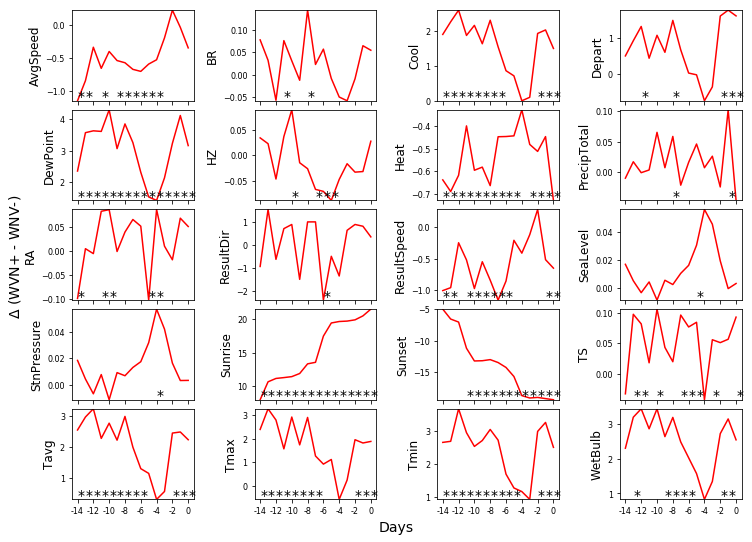

In [249]:
fig = plt.figure(figsize=(12,9))
for i, ind in enumerate(significant_inds):
    if i <= 15:
        ax = fig.add_subplot(5,4,i+1);
        plot_2weeks_diff_weather_data(ind, all_match_weather1_df, wnv_mask, output_df, plot_xlabel=False)
        ax.tick_params(axis='both', which='major', labelsize=8)
    else:
        ax = fig.add_subplot(5,4,i+1);
        plot_2weeks_diff_weather_data(ind, all_match_weather1_df, wnv_mask, output_df, plot_xlabel=True)
        ax.tick_params(axis='both', which='major', labelsize=8)
fig.text(0.5, 0.075, 'Days', ha='center', fontsize=14)
fig.text(0.05, 0.5, r'$\Delta$ (WVN+ - WNV-)', va='center', rotation='vertical', fontsize=14)
plt.subplots_adjust(wspace=0.5, hspace=0.1)

## Use weather data from closest station

In [18]:
all_match_weather_df = [match_weather_df, match1_weather_df, match2_weather_df, match3_weather_df, match4_weather_df, \
                       match5_weather_df, match6_weather_df, match7_weather_df, match8_weather_df, match9_weather_df, \
                       match10_weather_df, match11_weather_df, match12_weather_df, match13_weather_df, match14_weather_df]

In [19]:
alpha_corrected = 0.05/(len(match_weather_df.columns[1:])*15)
wnv_mask = train_df['WnvPresent'] > 0
output_df = pd.DataFrame(columns=['pValue', 'Parameter', 'WnvPosAvg', 'WnvNegAvg'])
ind = 0
for df in all_match_weather_df:
    for col in df.columns[1:]:
        wnv_pos_data = np.array(df[col][wnv_mask], dtype=float)
        wnv_neg_data = np.array(df[col][~wnv_mask], dtype=float)
        f, p = stats.ttest_ind(wnv_pos_data, wnv_neg_data)
        if p < alpha_corrected:
            output = [p, col, np.nanmean(wnv_pos_data), np.nanmean(wnv_neg_data)]
            output_df.loc[ind] = output
            ind += 1
            #print('%.2e  %s-%i. %.2f  %.2f' % (output[0], output[1], output[2], output[3], output[4]))
output_df = output_df.sort_values(['pValue'], ascending=True)
output_df.head(20)

,pValue,Parameter,WnvPosAvg,WnvNegAvg
12,9.507753e-32,DewPoint_1,63.270417,59.226821
79,1.038449e-31,DewPoint_10,62.802178,58.831944
106,2.726982e-28,WetBulb_13,67.252269,64.262783
94,2.922016e-27,Tmin_12,66.161525,62.781015
13,1.738473e-26,WetBulb_1,67.537205,64.513109
96,9.290876e-26,DewPoint_12,60.727768,57.260372
98,1.738941e-25,Cool_12,9.825771,7.270919
105,6.061129e-25,DewPoint_13,62.212341,58.843697
95,1.026699e-24,Tavg_12,74.566243,71.448619
117,2.087078e-24,AvgSpeed_14,6.954083,8.073079


In [122]:
significant_inds = []
significant_params = ['AvgSpeed', 'BR', 'Cool', 'DZ', 'DewPoint', 'FG', 'Heat', 'RA', 'ResultDir', 'ResultSpeed', \
                      'TS', 'Tavg', 'Tmax', 'Tmin', 'WetBulb']
for param in significant_params:
    ind = list(match_weather_df.columns).index('%s_0' % (param))
    significant_inds.append(ind)

print(len(significant_inds))

15


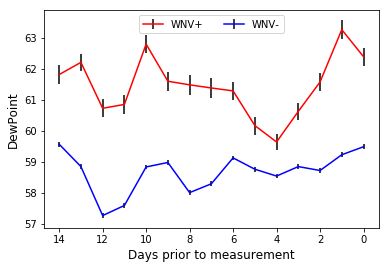

In [162]:
plot_2weeks_weather_data(5, all_match_weather_df, wnv_mask, legend=True)

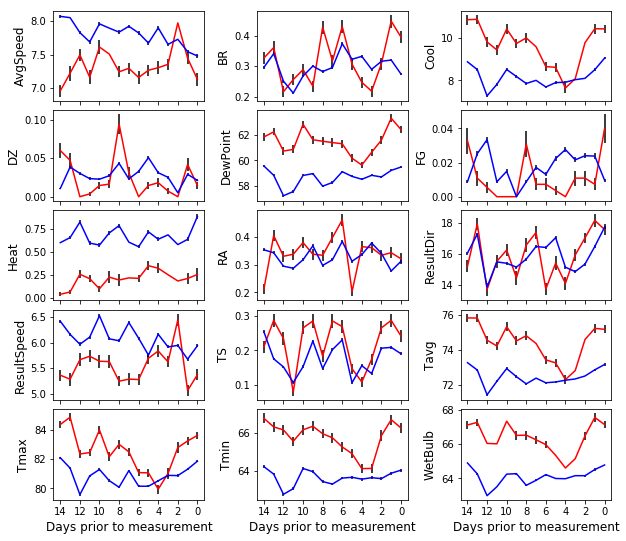

In [178]:
plt.figure(figsize=(10,9));
for i, ind in enumerate(significant_inds):
    plt.subplot(5,3,i+1);
    if i < 12:
        plot_2weeks_weather_data(ind, all_match_weather_df, wnv_mask, plot_xlabel=False)
    else:
        plot_2weeks_weather_data(ind, all_match_weather_df, wnv_mask, plot_xlabel=True)
plt.subplots_adjust(wspace=0.35, hspace=0.1)

In [254]:
spray_df

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
5,2011-08-29,6:57:48 PM,42.390395,-88.088315
6,2011-08-29,6:57:58 PM,42.390673,-88.088002
7,2011-08-29,6:58:08 PM,42.391027,-88.088002
8,2011-08-29,6:58:18 PM,42.391403,-88.088003
9,2011-08-29,6:58:28 PM,42.391718,-88.087995
